In [1]:
from pathlib import Path
import numpy as np
import SimpleITK as sitk
%matplotlib notebook
import multiscale.ultrasound.reconstruction as recon

import multiscale.itk.itk_plotting as iplt
import multiscale.itk.registration as reg
import multiscale.itk.process as proc
import multiscale.utility_functions as util

import matplotlib.pyplot as plt
import math
import pandas as pd
import tiffile as tif
import pickle
import os

In [2]:
def open_us(us_path, dynamic_range, spacing, origin):
    """Open the US image, window it to a dynamic range, and rotate it to microscope coordinate axes"""
    raw_image = sitk.ReadImage(str(us_path))
    windowed_image = proc.window_image(raw_image, dynamic_range)
    us_image = rotate_axes_to_microscope(windowed_image)
    us_image.SetSpacing(spacing)
    us_image.SetOrigin(origin)
    us_image.SetDirection([1, 0, 0, 0, 1, 0, 0, 0, -1])
    return us_image

def open_mpm(mpm_path, mpm_origin_path, mpm_spacing):
    """Open the MPM image and set the direction to -1 in Z to mirror microscope convention"""
    positions = positions_from_ometif(mpm_origin_path)
    origin = np.min(positions, 0)
    mpm_image = sitk.ReadImage(str(mpm_path))
    mpm_image.SetSpacing(mpm_spacing)
    mpm_image.SetOrigin(origin)
    mpm_image.SetDirection([1, 0, 0, 0, 1, 0, 0, 0, -1])
    return mpm_image

def rotate_axes_to_microscope(image):
    """Rotate the US axes to be along the microscope axes"""
    arr = sitk.GetArrayFromImage(image)
    arr_rot = np.swapaxes(arr, 0, 1)
    arr_rot = np.flip(arr_rot, 0).astype(np.uint8)
    return sitk.GetImageFromArray(arr_rot)

def positions_from_ometif(file_path):
    """Read a .ome.tif file and grab the image positions as a numpy array"""
    reader = sitk.ImageFileReader()
    reader.SetFileName(str(file_path))
    reader.ReadImageInformation()
    raw_info = reader.GetMetaData('ImageDescription')
    info = tif.xml2dict(raw_info)
    mpm_list = []
    for position in info['OME']['Image']:
        x = position['StageLabel']['X']
        y = position['StageLabel']['Y']
        z = position['Pixels']['Plane'][0]['PositionZ']
        mpm_list.append(np.array([x, y, z]))
    return np.array(mpm_list)

def get_xy_origin(pl_path):
    """Read an ultrasound position list and get the XY origin"""
    raw_pos_list = util.read_json(pl_path)
    pos_list = recon.clean_position_text(raw_pos_list)[0]
    xy_origin = np.min(pos_list, 0)
    return xy_origin

def connected_components(us_image):
    """Process the US image using Otsu thresholding and binary opening/closing to get the connected components"""
    thresh_filter = sitk.OtsuThresholdImageFilter()
    thresh_filter.SetInsideValue(0)
    thresh_filter.SetOutsideValue(1)
    thresh_img = thresh_filter.Execute(us_image)
    thresh_value = thresh_filter.GetThreshold()

    print("Threshold used: " + str(thresh_value))

    cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(thresh_img, [4, 4, 2])
    cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [4, 4, 2])

    connected_img = sitk.ConnectedComponent(cleaned_thresh_img)
    return connected_img

def get_fiducial_stats(connected_img):
    """Get statistics for each object in a label image"""
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.ComputeOrientedBoundingBoxOn()
    stats.ComputePerimeterOn()
    stats.Execute(connected_img)    
    return stats

def filter_labels(stats):
    """Filter labels by property so you only get the fiducial circles"""
    return [l for l in stats.GetLabels() if (stats.GetNumberOfPixels(l) < 300000 
                                             and stats.GetEquivalentEllipsoidDiameter(l)[1] > 2000)]

def get_leveled_centroid(stats, true_labels):
    """Get the leveled Z height, equivalent to the bottom of fiducial, for each label"""
    centroid = [stats.GetCentroid(l) for l in true_labels]
    level_center = []
    idx = 0
    for center in centroid:
        level_center.append(center[2] + np.floor((idx+3)/3)*1000)
        idx = idx+1
    return np.array(level_center)

def get_ellipsoid_radius(stats, true_labels):
    """Get the equivalent radius of objects in Z"""
    rad = [0.5*stats.GetEquivalentEllipsoidDiameter(l)[0] for l in true_labels]
    return rad

def apply_transform(moving_image, fixed_image, transform_params):
    """Apply a rigid transform based on input parameters"""
    transform = sitk.VersorRigid3DTransform()
    transform.SetParameters(transform_params)
    reg = sitk.Resample(moving_image, fixed_image, transform, sitk.sitkLinear, 0.0, fixed_image.GetPixelID())
    return reg

def calculate_centroid(image):
    stats = get_fiducial_stats(image)
    labels = filter_labels(stats)
    centroids = get_leveled_centroid(stats, labels)
    return centroids

In [3]:
fiducial_dir = Path(r'F:\Research\LINK\Phantom Trials\Fiducial paper analysis')
registered_dir = Path(r'F:\Research\LINK\Phantom Trials\Fiducial paper analysis\Registered')
metadata_dir = Path(r'F:\Research\LINK\Phantom Trials\Fiducial paper analysis\Metadata images')
mpm_dir = Path(r'F:\Research\LINK\Phantom Trials\Fiducial paper analysis\MPM Images\MPM downsampled')
us_dir = Path(r'F:\Research\LINK\Phantom Trials\Fiducial paper analysis\Ultrasound')


# Rotation

In [4]:
# All US images are on the same positions list for X and Y.  Each has a slightly different Z height based on the indicator gauge
us_pl_path = Path(r'C:\Users\mpinkert\Box\Research\LINK\Phantom Trials\2019-05-04\2019-05-04_US - 3X 100YSep.pos')
us_xy_origin = get_xy_origin(us_pl_path)

# These Z heights are recorded from the gauge and are in microns.
us_heights = [0, -6, -6, -7, -6]
us_origins = [np.array([us_xy_origin[0], us_xy_origin[1], us_heights[idx]]) for idx in range(5)]

In [5]:
us_origins[0]

array([-10128.11, -10999.92,      0.  ])

In [5]:
# The MPM positions 
mpm_origins = [Path(metadata_dir, 'Fiducial acq ' + str(idx+1) + '.ome.tif') for idx in range(5)]

In [6]:
# Assign spacing manually
us_spacing = [25, 25, 25]
mpm_spacing = [8.16, 8.16, 25]
dynamic_range = 50

In [7]:
# Specify where the images are.
mpm_paths = [Path(mpm_dir, 'MPM acq {}_8x.tif'.format(str(idx))) for idx in range(1, 6)]
us_paths = [Path(us_dir, 'US Rotation {}.tif'.format(str(idx))) for idx in range(1, 6)]

In [8]:
mpm_images = [open_mpm(mpm_paths[idx], mpm_origins[idx], mpm_spacing) for idx in range(5)]

In [9]:
us_images = [open_us(us_paths[idx], dynamic_range, us_spacing, us_origins[idx]) for idx in range(5)]

In [10]:
# Acquire points manually for the XY registrations.
points = []

<IPython.core.display.Javascript object>


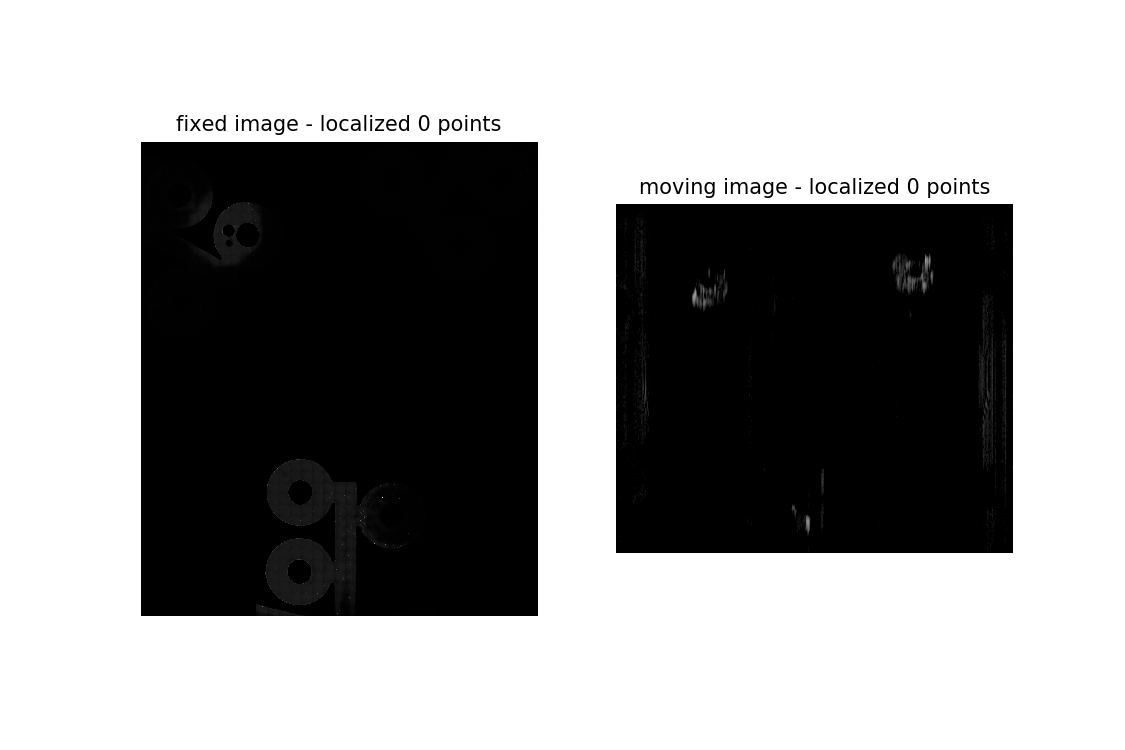

In [11]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[0], us_images[0]))

<IPython.core.display.Javascript object>


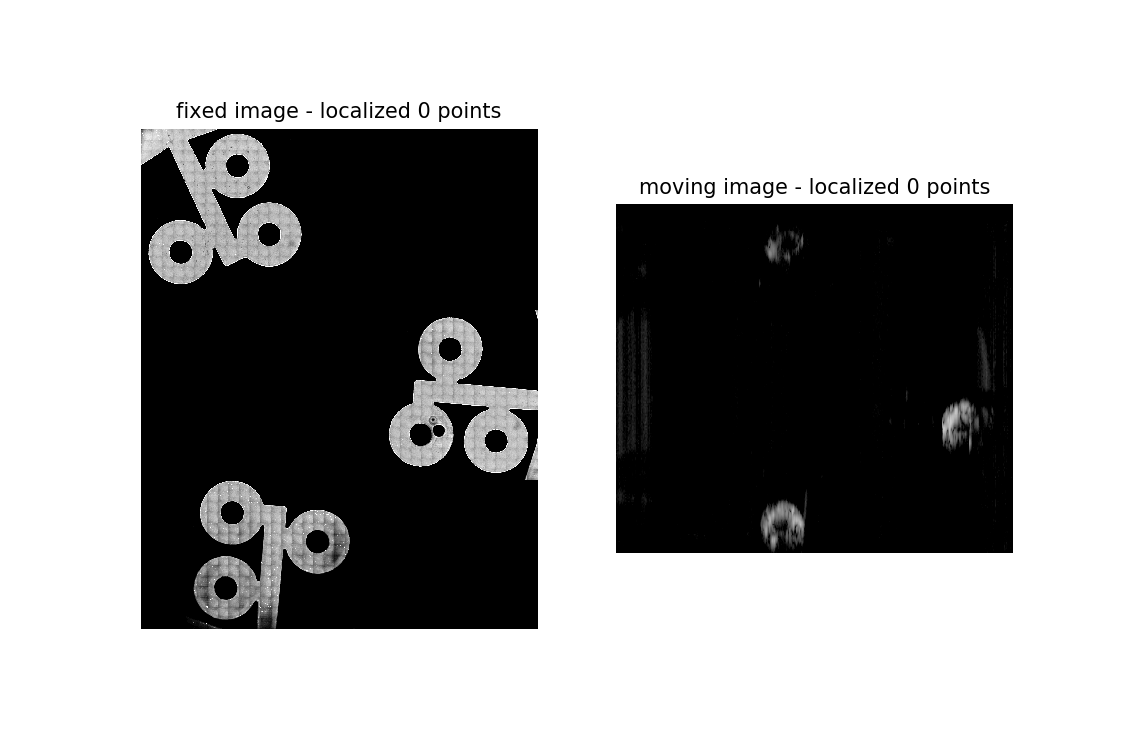

In [12]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[1], us_images[1]))

<IPython.core.display.Javascript object>


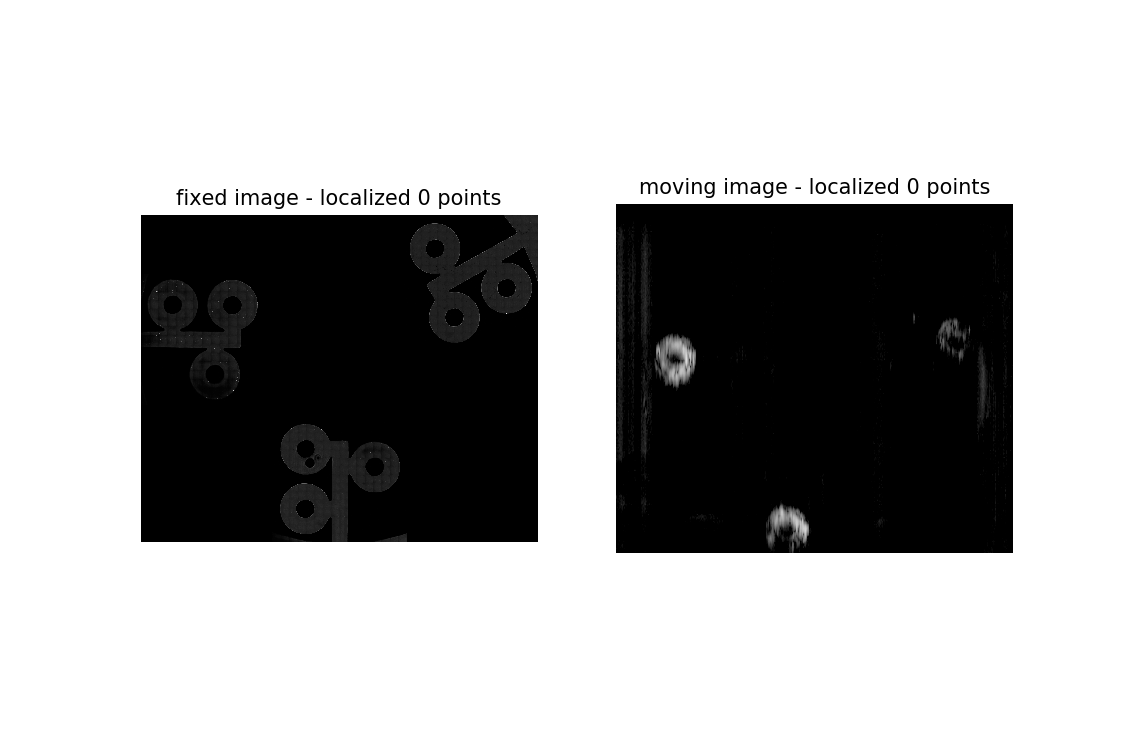

In [13]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[2], us_images[2]))

<IPython.core.display.Javascript object>


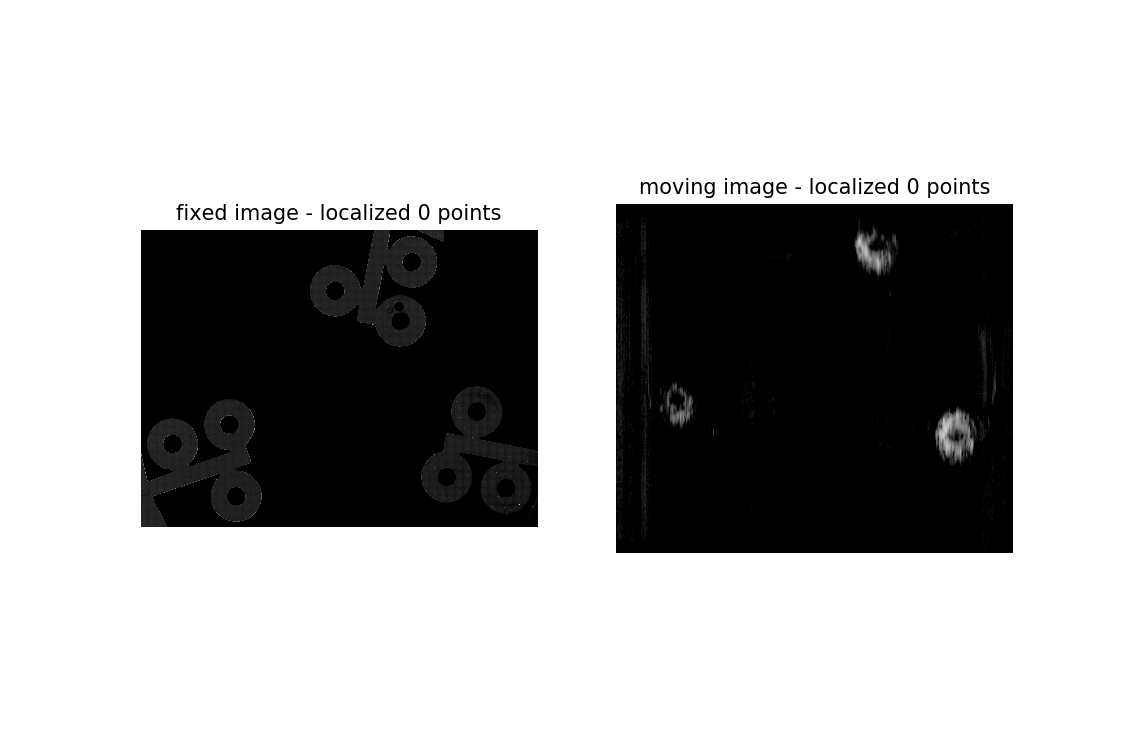

In [14]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[3], us_images[3]))

<IPython.core.display.Javascript object>


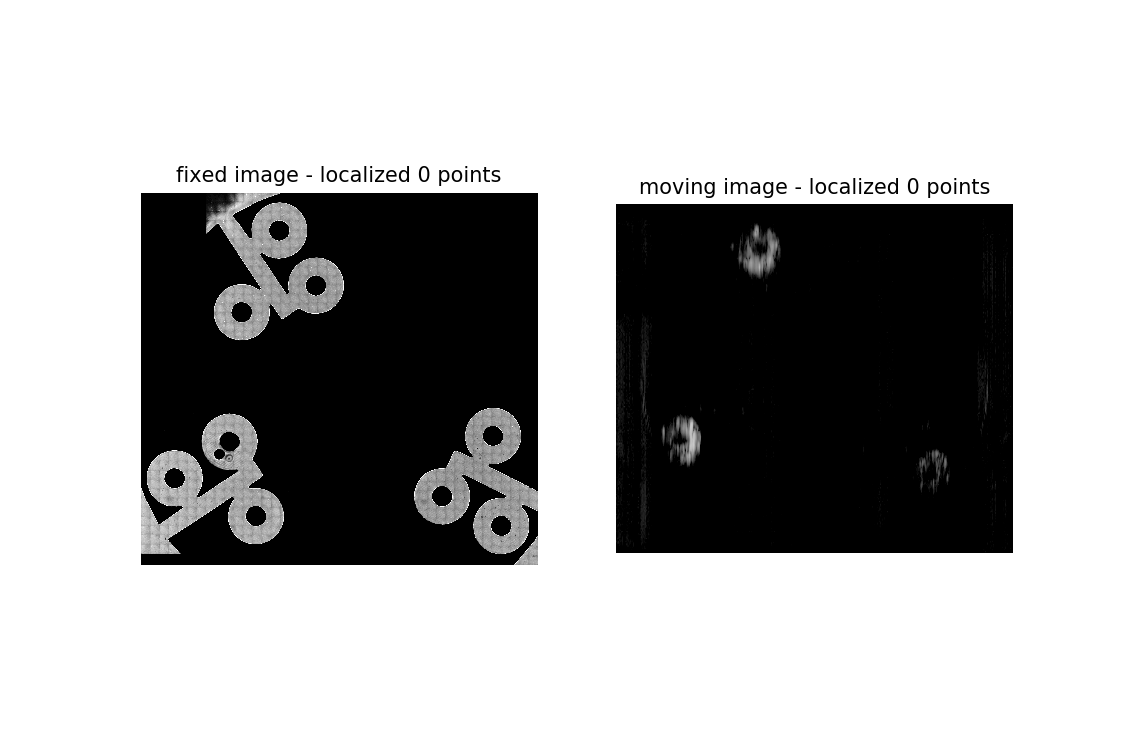

In [15]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[4], us_images[4]))

In [16]:
fixed_points = []
moving_points = []
for idx in range(5):
    fixed, moving = points[idx].get_points_flat()
    fixed_points.append(fixed)
    moving_points.append(moving)

In [17]:
fixed_points_path = Path(fiducial_dir, 'Rotation init points - fixed.txt')
moving_points_path = Path(fiducial_dir, 'Rotation init points - moving.txt')

In [18]:
# Points previously acquired
if len(fixed_points[0]) == 0:
    with open(fixed_points_path, 'rb') as fp:
        fixed_points = pickle.load(fp)   
    with open(moving_points_path, 'rb') as fp:
        moving_points = pickle.load(fp)
else:
    with open(fixed_points_path, 'wb') as fp:
        pickle.dump(fixed_points, fp)
    with open(moving_points_path, 'wb') as fp:
        pickle.dump(moving_points, fp)

In [19]:
final_params = []
metrics = []
stops = []

In [ ]:
for idx in range(5):
    initial_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), fixed_points[idx], moving_points[idx])
    final_transform, metric, stop = reg.register(mpm_images[idx], us_images[idx], initial_transform=initial_transform)
    final_params.append(final_transform.GetParameters())
    metrics.append(metric)
    stops.append(stop)
    print('Finished registration {}'.format(idx+1))

In [20]:
rotation_params_path = Path(fiducial_dir, 'Rotation XY parameters.txt')

if len(final_params) == 0:
    with open(rotation_params_path, 'rb') as fp:
        final_params = pickle.load(fp)
else:
    with open(rotation_params_path, 'wb') as fp:
        pickle.dump(final_params, fp)

In [21]:
transform_mean = np.mean(np.array(final_params), 0)
transform_std = np.std(np.array(final_params), 0)
print(transform_mean)
print(transform_std)

[ 1.38556056e-04 -1.99190974e-04 -4.06904111e-04  4.57335153e+03
  1.68307002e+03 -1.07383803e+03]
[6.62406652e-04 9.51442500e-04 2.59517584e-04 4.59803447e+00
 1.18554707e+01 8.50002209e+01]


In [ ]:
registered_images = []
for idx in range(5):
    transform = sitk.VersorRigid3DTransform()
    transform.SetParameters(final_params[idx])
    registered_images.append(sitk.Resample(us_images[idx], mpm_images[idx], transform, sitk.sitkLinear, 0.0, mpm_images[idx].GetPixelID()))

In [ ]:
for idx in range(5):
    reg_path = Path(registered_dir, 'US Rot Reg {}.tif'.format(idx+1))
    sitk.WriteImage(registered_images[idx], str(reg_path))

# Height determination

In [22]:
rot_conn = [connected_components(image[:, :, 40:165]) for image in us_images]

Threshold used: 52.0
Threshold used: 52.0
Threshold used: 52.0
Threshold used: 54.0
Threshold used: 54.0


In [25]:
rot_centroids = np.array([calculate_centroid(image) for image in rot_conn])

In [26]:
fiducial_bottom = np.mean(rot_centroids)
bottom_std = np.std(rot_centroids)
print(fiducial_bottom)
print(bottom_std)

-896.4997245476209
67.34951021097717


In [27]:
# -4 * 25 because the fiducial first fully appears on the fifth slice
z_translation = -1*(mpm_images[0].GetOrigin()[2] - 4*25 - fiducial_bottom)
z_translation

28.500275452379128

In [32]:
coordinate_transform = transform_mean.copy()
coordinate_transform[5] = z_translation

In [33]:
coordinate_path = Path(fiducial_dir, 'Coordinate transform.txt')
try:
    with open(coordinate_path, 'wb') as fp:
        pickle.dump(coordinate_transform, fp)
except NameError:
    with open(coordinate_path, 'rb') as fp:
        coordinate_transform = pickle.load(fp)

In [34]:
height_transforms = [coordinate_transform.copy() for idx in range(4)]
for idx in range(4):
    height_transforms[idx][5] = height_transforms[idx][5] - 1000*(idx)

In [ ]:
height_reg = [apply_transform(us_images[0], mpm_images[0], height_transforms[idx]) for idx in range(4)]

In [ ]:
for idx in range(4):
    reg_path = Path(registered_dir, 'US Height Reg {}mm.tif'.format(idx))
    sitk.WriteImage(height_reg[idx], str(reg_path))

In [ ]:
us_all_reg = height_reg[1] + height_reg[2] + height_reg[3]
reg_path = Path(registered_dir, 'US Height All Reg.tif')
sitk.WriteImage(us_all_reg, str(reg_path))

In [ ]:
mpm_reg = [apply_transform(mpm_images[0], us_images[0], -1*height_transforms[idx]) for idx in range(4)]

In [ ]:
for idx in range(4):
    reg_path = Path(registered_dir, 'MPM Height Reg {}mm.tif'.format(idx))
    sitk.WriteImage(mpm_reg[idx], str(reg_path))

In [ ]:
mpm_all_reg = mpm_reg[0] + mpm_reg[1] + mpm_reg[2] + mpm_reg[3]
reg_path = Path(registered_dir, 'MPM Height All Reg.tif')
sitk.WriteImage(mpm_all_reg, str(reg_path))

## Tendon

In [ ]:
tendon_us_path = Path(us_dir, 'Tendon 2.tif')
tendon_origin = [us_xy_origin[0], us_xy_origin[1], 4]
us_tendon = open_us(tendon_us_path, dynamic_range, us_spacing, tendon_origin)

tendon_mpm_path = Path(mpm_dir, 'Tendon 2.tif')
tendon_origin_path = Path(metadata_dir, 'Tendon 2.ome.tif')
mpm_tendon = open_mpm(tendon_mpm_path, tendon_origin_path, [8.16, 8.16, 8.16])

In [ ]:
tendon_reg = apply_transform(us_tendon, mpm_tendon, height_transforms[0])
reg_path = Path(registered_dir, 'US Tendon 2.tif')
sitk.WriteImage(tendon_reg, str(reg_path))

In [ ]:
tendon_mpm_reg = apply_transform(mpm_tendon, us_tendon, -1*height_transforms[0])
reg_path = Path(registered_dir, 'MPM Tendon 2.tif')
sitk.WriteImage(tendon_mpm_reg, str(reg_path))

# Height change determination

In [42]:
height_image_names = [image for image in os.listdir(us_dir) if (image.startswith('US_H'))]
# The +25 is because the image had an extra axial sample for H-1000 and H500
height_z = [-4+25, -10, -2, 12, 12, 7, 2+25]
height_image_names

['US_H-1000_F-7mm.tif',
 'US_H-2000_F-7mm.tif',
 'US_H-500_F-7mm.tif',
 'US_H1000_F-7mm.tif',
 'US_H2000_F-7mm.tif',
 'US_H500_F-7mm.tif']

In [43]:
height_images = [open_us(Path(us_dir, height_image_names[idx]), dynamic_range, us_spacing, 
                         np.array([us_xy_origin[0], us_xy_origin[1], height_z[idx]]))
                 for idx in range(len(height_image_names))]

In [44]:
connected_images = [connected_components(image[:, :, 40:170]) for image in height_images]

Threshold used: 52.0
Threshold used: 48.0
Threshold used: 52.0
Threshold used: 48.0
Threshold used: 38.0
Threshold used: 50.0


In [45]:
height_centroids = np.array([calculate_centroid(image) for image in connected_images])

In [48]:
mean_diffs = [np.mean(centroid - np.mean(rot_centroids[0])) for centroid in height_centroids]
mean_diffs

[18.43773909723984,
 17.781019216055242,
 16.33454484008218,
 9.474628125224235,
 -142.66864844104703,
 -81.67889066825656]

In [56]:
height_points = []

<IPython.core.display.Javascript object>


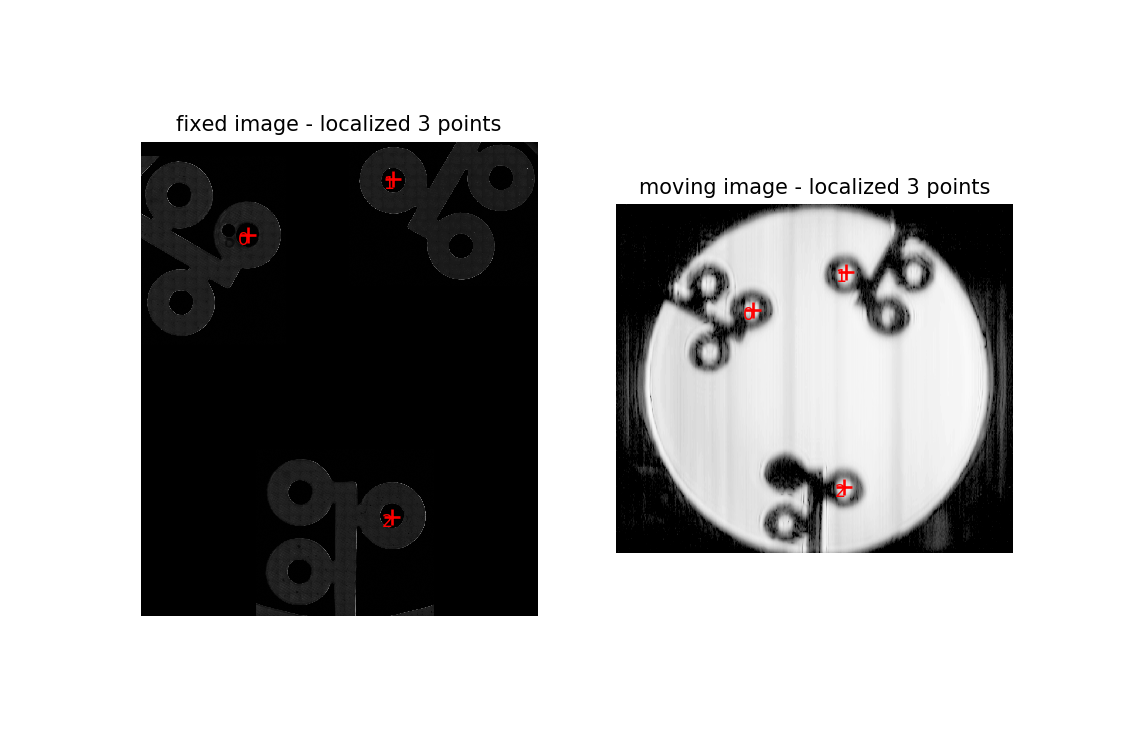

In [57]:
height_points.append(iplt.RegistrationPointDataAcquisition(mpm_images[0], height_images[0]))

<IPython.core.display.Javascript object>


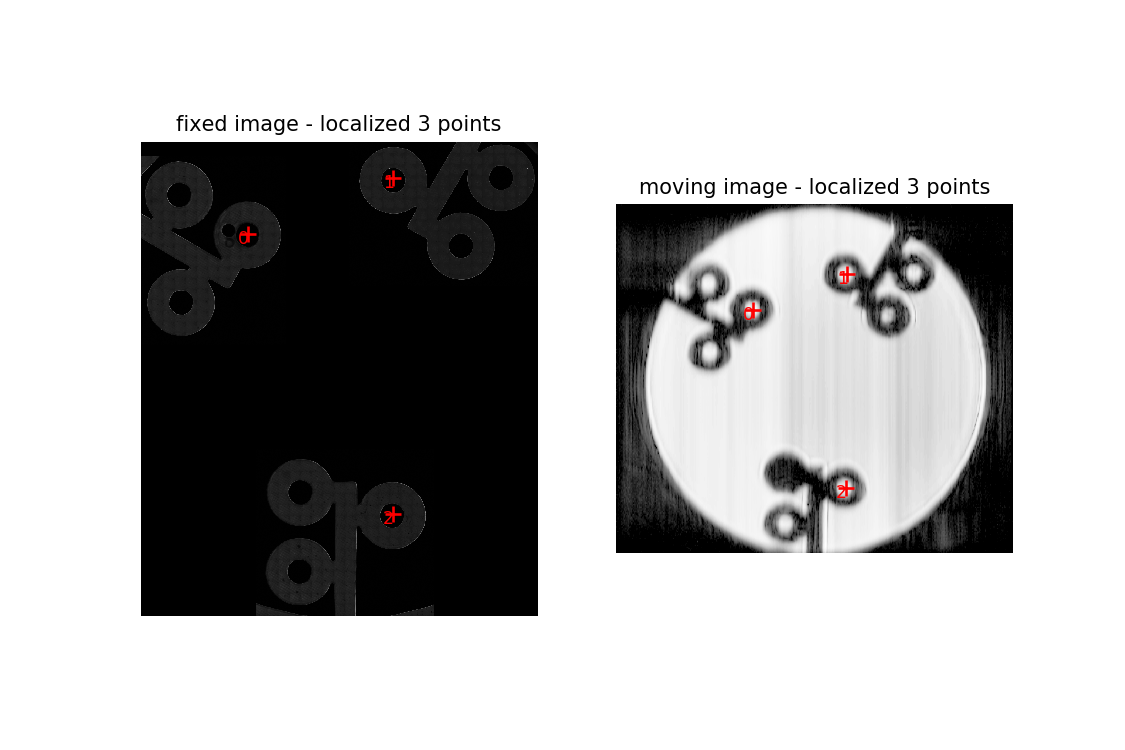

In [58]:
height_points.append(iplt.RegistrationPointDataAcquisition(mpm_images[0], height_images[1]))

<IPython.core.display.Javascript object>


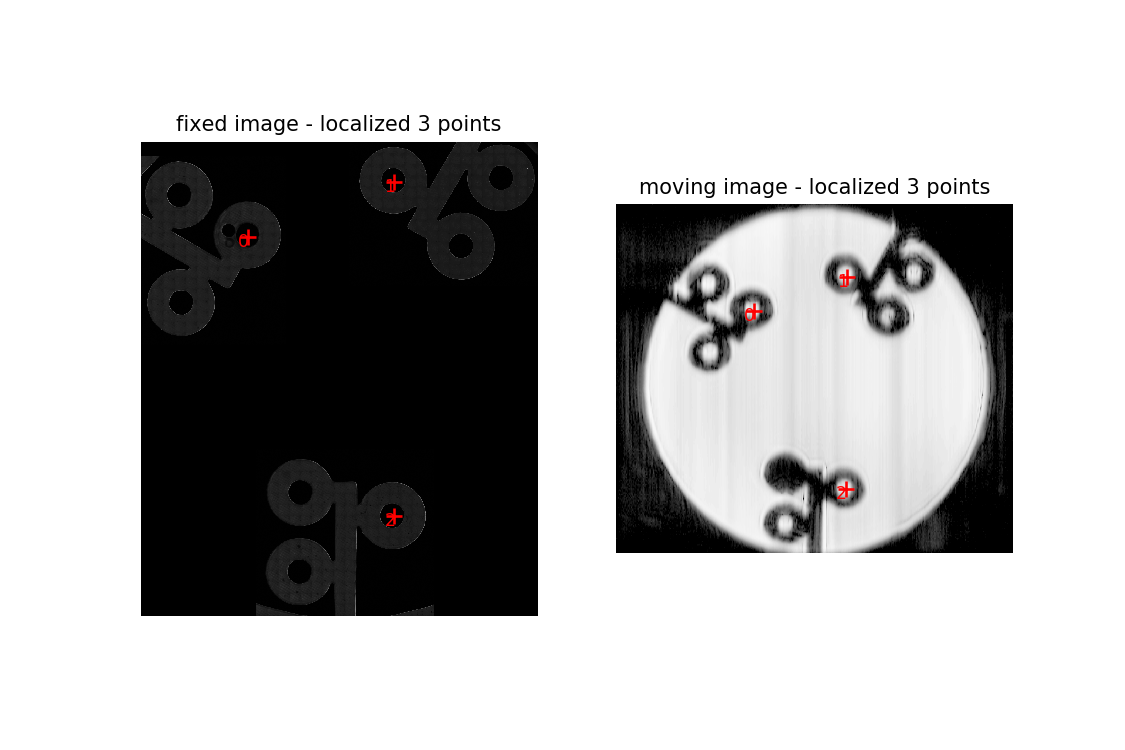

In [59]:
height_points.append(iplt.RegistrationPointDataAcquisition(mpm_images[0], height_images[2]))

<IPython.core.display.Javascript object>


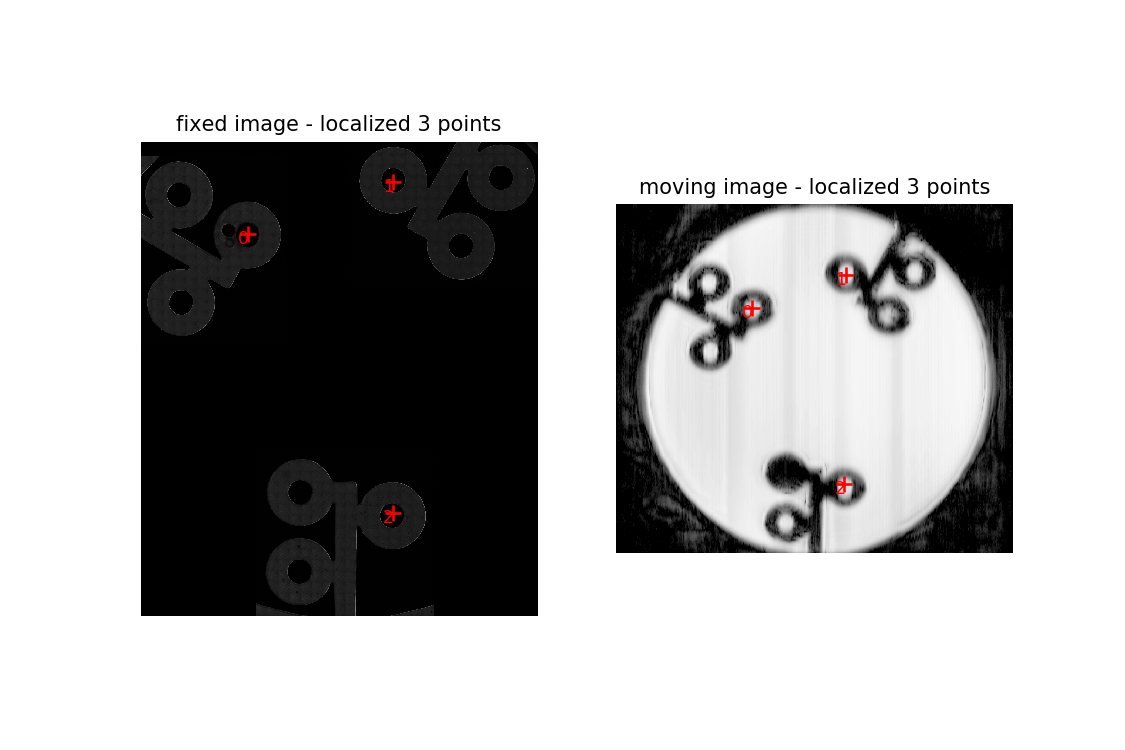

In [60]:
height_points.append(iplt.RegistrationPointDataAcquisition(mpm_images[0], height_images[3]))

<IPython.core.display.Javascript object>


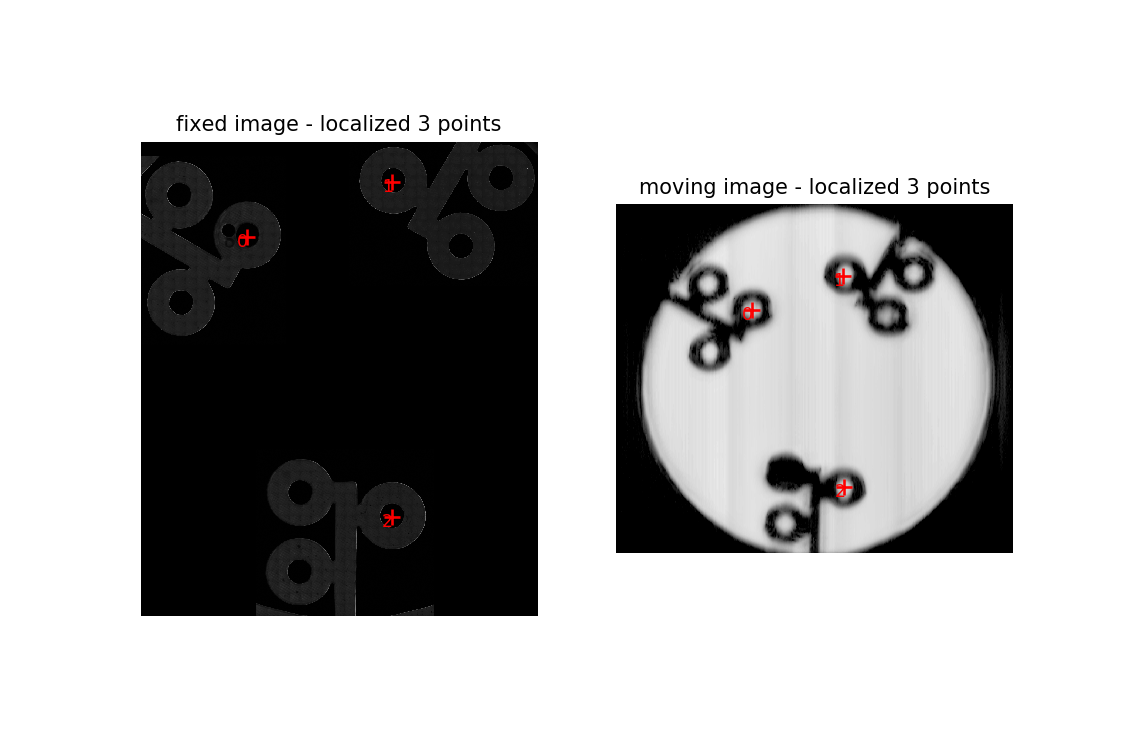

In [61]:
height_points.append(iplt.RegistrationPointDataAcquisition(mpm_images[0], height_images[4]))

<IPython.core.display.Javascript object>


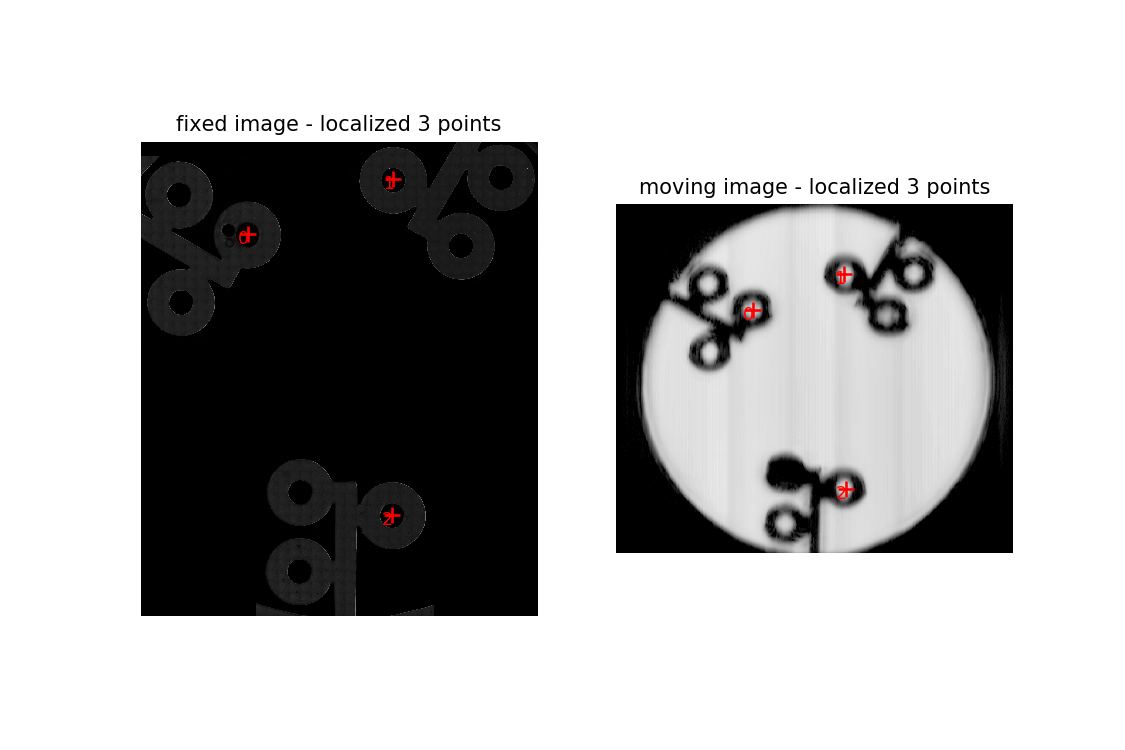

In [62]:
height_points.append(iplt.RegistrationPointDataAcquisition(mpm_images[0], height_images[5]))

In [64]:
height_points

In [65]:
fixed_height_points = []
moving_height_points = []
for idx in range(len(height_points)):
    fixed, moving = height_points[idx].get_points_flat()
    fixed_height_points.append(fixed)
    moving_height_points.append(moving)

In [66]:
fixed_height_path = Path(fiducial_dir, 'Rotation init points - fixed height.txt')
moving_height_path = Path(fiducial_dir, 'Rotation init points - moving height.txt')

In [67]:
# Points previously acquired
if len(fixed_height_points[0]) == 0:
    with open(fixed_height_path, 'rb') as fp:
        fixed_height_points = pickle.load(fp)   
    with open(moving_height_path, 'rb') as fp:
        moving_height_points = pickle.load(fp)
else:
    with open(fixed_height_path, 'wb') as fp:
        pickle.dump(fixed_height_points, fp)
    with open(moving_height_path, 'wb') as fp:
        pickle.dump(moving_height_points, fp)

In [68]:
final_height_params = []
metrics_height = []
stops_height = []

In [69]:
for idx in range(len(height_images)):
    initial_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), fixed_height_points[idx], moving_height_points[idx])
    final_transform, metric, stop = reg.register(mpm_images[0], height_images[idx], initial_transform=initial_transform)
    final_height_params.append(final_transform.GetParameters())
    metrics_height.append(metric)
    stops_height.append(stop)
    print('Finished registration {}'.format(idx+1))

Finished registration 1
Finished registration 2
Finished registration 3
Finished registration 4
Finished registration 5
Finished registration 6


In [70]:
height_params_path = Path(fiducial_dir, 'Height XY parameters.txt')

if len(final_height_params) == 0:
    with open(height_params_path, 'rb') as fp:
        final_height_params = pickle.load(fp)
else:
    with open(height_params_path, 'wb') as fp:
        pickle.dump(final_height_params, fp)

In [71]:
height_mean = np.mean(np.array(final_height_params), 0)
height_std = np.std(np.array(final_height_params), 0)
print(height_mean)
print(height_std)

[-3.17402881e-05  7.33848005e-04 -3.75986359e-04  4.54037216e+03
  1.70395599e+03  7.13845510e+02]
[3.36034518e-04 4.51051357e-04 1.50763251e-04 2.00264881e+01
 2.38964450e+01 4.95585644e+01]


In [73]:
x_diffs = [np.mean(param[3] - transform_mean[3]) for param in final_height_params]
y_diffs = [np.mean(param[4] - transform_mean[4]) for param in final_height_params]
print(x_diffs)
print(y_diffs)


[-43.57552219855006, -45.50829950130537, -45.36352806019022, 11.026107263286576, -39.59036750721316, -34.86461704150497]
[32.56015885951933, 16.577186370733898, 28.413848267517096, -29.4610665404673, 43.6829216709923, 33.54275295005641]


In [74]:
print(np.mean(x_diffs))
print(np.mean(y_diffs))

-32.979371174246204
20.88596692972529
